In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

In [2]:
num_samples = 20

# Coadapt baseline
file_list = [
    f"comp256_v5/FISTA_fnorm1e-3",
    f"comp256_v5/gaussian_{num_samples}samp",
    f"comp256_v5/laplacian_{num_samples}samp",
    f"comp256_v5/concreteslab_{num_samples}samp",
    f"comp256_v5/gaussian_thresh_{num_samples}samp",
    f"comp256_v5/gaussian_learnthresh_{num_samples}samp",
    f"comp256_v5/laplacian_thresh_{num_samples}samp",
    f"comp256_v5/laplacian_learnthresh_{num_samples}samp",
]

file_labels = [
    "FISTA",
    "Gaussian",
    "Laplacian",
    "Spike-Slab",
    "Thresh Gaussian",
    "Thresh Gaussian+Gamma",
    "Thresh Laplacian",
    "Thresh Laplacian+Gamma",
]

file_list = [
    #"comp256/FISTA_fnorm1e-4/",
    "comp256_v6/laplacian_avg_thresh_20samp",
    "comp256_v6/laplacian_avg_thresh_100samp",
    #"comp256_v3/laplacian_iwae_thresh_20samp",
    #"comp256_v3/laplacian_iwae_thresh_100samp",
    "comp256_v6/laplacian_max_thresh_20samp",
    "comp256_v6/laplacian_max_thresh_100samp",
]

file_labels = [
    #"FISTA",
    "Avg 20samp",
    "Avg 100samp",
    #"IWAE 20samp",
    #"IWAE 100samp",
    "Max 20samp",
    "Max 100samp",
]

file_list = [[file_list[i] + "_v1/", file_list[i] + "_v2/", file_list[i] + "_v3/"] for i in range(len(file_list))]
file_list = [item for sublist in file_list for item in sublist]

file_labels = [[file_labels[i] + " v1", file_labels[i] + " v2", file_labels[i] + " v3"] for i in range(len(file_labels))]
file_labels = [item for sublist in file_labels for item in sublist]

training_step = "train_savefile.npz"
learned_dictionary = {}
val_true_recon = {}
val_recon = {} 
val_l1 = {} 
val_iwae_loss = {}
val_true_l1 = {}
val_kl_loss = {} 
coeff_est = {} 
coeff_true = {}
num_true_supp = {}
num_redundant_supp = {}
est_active_coeff = {}
true_active_coeff = {}
classification_acc = {}
dictionary_use_dict = {}

multi_info = {}
stat_step = {}
posterior_collapse = {}
coeff_collapse = {}

In [3]:
for idx, file in enumerate(file_list):
    data_file = np.load(file + training_step)
    learned_dictionary[file_labels[idx]] = data_file['phi']
    val_true_recon[file_labels[idx]] = data_file['val_true_recon']
    val_recon[file_labels[idx]] = data_file['val_recon']
    val_l1[file_labels[idx]] = data_file['val_l1']
    val_true_l1[file_labels[idx]] = data_file['val_true_l1']
    val_kl_loss[file_labels[idx]] = data_file['val_kl_loss']
    val_iwae_loss[file_labels[idx]] = data_file['val_iwae_loss']
    coeff_est[file_labels[idx]] = data_file['coeff_est']
    coeff_true[file_labels[idx]] = data_file['coeff_true']
    num_true_supp[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))
    num_redundant_supp[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))
    true_active_coeff[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))
    est_active_coeff[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))   
    classification_acc[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))    
    dictionary_use_dict[file_labels[idx]] = data_file['dictionary_use']

    for i in range(len(coeff_true[file_labels[idx]])):
        for j in range(coeff_true[file_labels[idx]].shape[1]):
            true_sup = np.nonzero(coeff_true[file_labels[idx]][i, j])[0]
            est_sup = np.nonzero(coeff_est[file_labels[idx]][i, j])[0]
            missed_support = np.setdiff1d(true_sup, est_sup)
            excess_support = np.setdiff1d(est_sup, true_sup)
            true_active_coeff[file_labels[idx]][i] += len(true_sup) / coeff_true[file_labels[idx]].shape[2]
            est_active_coeff[file_labels[idx]][i] += len(est_sup) / coeff_est[file_labels[idx]].shape[2]
            num_true_supp[file_labels[idx]][i] += (1 - (len(missed_support) / coeff_est[file_labels[idx]].shape[2]))
            num_redundant_supp[file_labels[idx]][i] += (len(excess_support) / coeff_est[file_labels[idx]].shape[2])
            classification_acc[file_labels[idx]][i] += (coeff_est[file_labels[idx]].shape[2] - len(missed_support) - len(excess_support)) 
        true_active_coeff[file_labels[idx]][i] /= coeff_true[file_labels[idx]].shape[1]
        est_active_coeff[file_labels[idx]][i] /= coeff_est[file_labels[idx]].shape[1]
        num_true_supp[file_labels[idx]][i] /= coeff_true[file_labels[idx]].shape[1]
        num_redundant_supp[file_labels[idx]][i] /= coeff_est[file_labels[idx]].shape[1]
        classification_acc[file_labels[idx]][i] /= (coeff_est[file_labels[idx]].shape[1] * coeff_est[file_labels[idx]].shape[2])

    stat_file = np.load(file + 'encoder_statistics.npz')
    multi_info[file_labels[idx]] = stat_file['multi_info']
    posterior_collapse[file_labels[idx]] = stat_file['posterior_collapse']
    coeff_collapse[file_labels[idx]] = stat_file['coeff_collapse']    
    stat_step[file_labels[idx]] = stat_file['load_list']
    #stat_step[file_labels[idx]] = list(range(0, 299, 20)) + [299]

Avg 20samp v1: val loss: 1.943E+02, MI: 1.732E+02, iwae: 1.540E+00,
Avg 20samp v2: val loss: 1.905E+02, MI: 1.709E+02, iwae: 1.516E+00,
Avg 20samp v3: val loss: 1.948E+02, MI: 1.738E+02, iwae: 1.566E+00,
Avg 100samp v1: val loss: 1.937E+02, MI: 1.710E+02, iwae: 1.526E+00,
Avg 100samp v2: val loss: 1.900E+02, MI: 1.707E+02, iwae: 1.498E+00,
Avg 100samp v3: val loss: 1.943E+02, MI: 1.727E+02, iwae: 1.548E+00,
Max 20samp v1: val loss: 1.955E+02, MI: 1.911E+02, iwae: 1.745E+00,
Max 20samp v2: val loss: 1.924E+02, MI: 1.908E+02, iwae: 1.726E+00,
Max 20samp v3: val loss: 1.950E+02, MI: 1.909E+02, iwae: 1.735E+00,
Max 100samp v1: val loss: 1.920E+02, MI: 1.916E+02, iwae: 1.666E+00,
Max 100samp v2: val loss: 1.890E+02, MI: 1.915E+02, iwae: 1.645E+00,
Max 100samp v3: val loss: 1.912E+02, MI: 1.909E+02, iwae: 1.653E+00,


Text(0, 0.5, 'Redundancy Reduction')

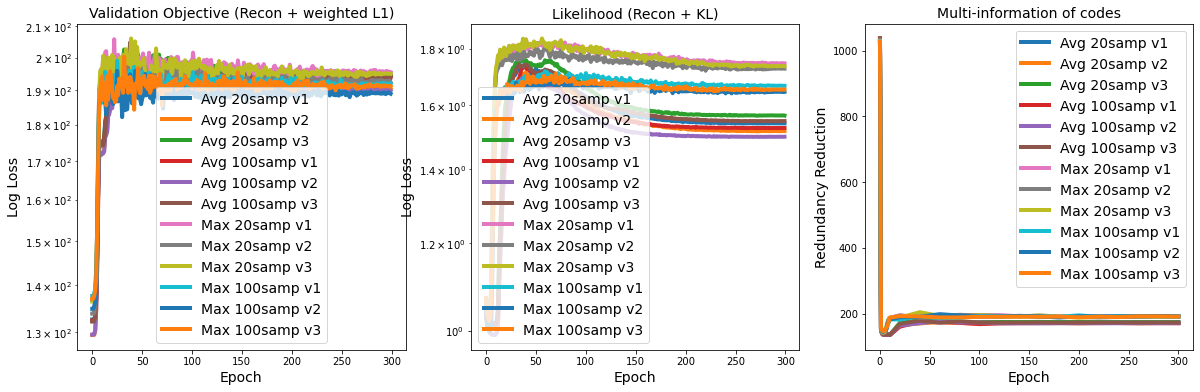

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
lamb = 20
fnorm = 1e-3

for idx, label in enumerate(file_labels):
    #    ax[0].semilogy(val_true_recon["Thresholded Gaussian"] + 0.2 * val_true_l1["Thresholded Gaussian"], linewidth=4, label="FISTA")
    #    ax[1].plot(np.zeros(len(val_iwae_loss[label])), linewidth=4, label="FISTA")
    #    ax[2].plot(stat_step[label], 4.706e+02 * np.ones(len(multi_info[label])), linewidth=4, label="FISTA")
    fnorm_penalty = np.linalg.norm(learned_dictionary[label][-1], ord='fro')**2
    ax[1].semilogy(val_iwae_loss[label], linewidth=4, label=label)
    ax[0].semilogy(val_recon[label] + (lamb * val_l1[label]) + (fnorm * fnorm_penalty), linewidth=4, label=label)
    ax[2].plot(stat_step[label], multi_info[label], linewidth=4, label=label)
    print(f"{label}: val loss: {val_recon[label][-1] + (lamb * val_l1[label][-1]) + (fnorm * fnorm_penalty):.3E}, MI: {multi_info[label][-1]:.3E}, iwae: {val_iwae_loss[label][-1]:.3E},")

ax[0].legend(fontsize=14)
ax[0].set_title("Validation Objective (Recon + weighted L1)", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].set_ylabel("Log Loss", fontsize=14)

ax[1].legend(fontsize=14)
ax[1].set_title("Likelihood (Recon + KL)", fontsize=14)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].set_ylabel("Log Loss", fontsize=14)

ax[2].legend(fontsize=14)
ax[2].set_title("Multi-information of codes", fontsize=14)
ax[2].set_xlabel("Epoch", fontsize=14)
ax[2].set_ylabel("Redundancy Reduction", fontsize=14)

/tmp/ipykernel_1332387/952427771.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, 0].semilogy(np.linalg.norm(coeff_est[label] - coeff_true[label], axis=-1).mean(axis=1), linewidth=4, label=label)


Text(0, 0.5, 'Log Mean Value')

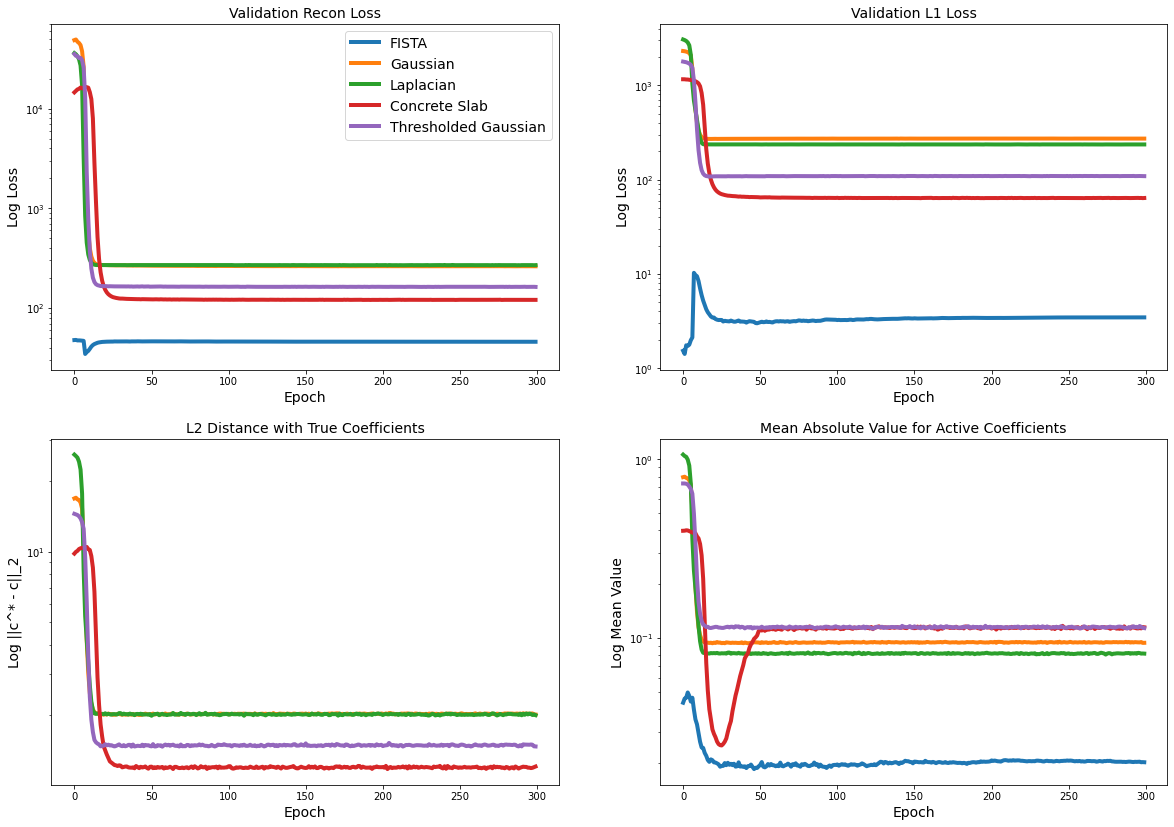

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

for idx, label in enumerate(file_labels):
    if idx == 0:
        ax[0, 0].semilogy(val_true_recon[label], linewidth=4, label="FISTA")
        ax[0, 1].semilogy(val_true_l1[label], linewidth=4, label="FISTA")
        ax[1, 0].plot(np.zeros(len(coeff_est[label])), linewidth=4, label="FISTA")
        ax[1, 1].semilogy(np.abs(coeff_true[label]).sum(axis=(1, 2)) / np.count_nonzero(coeff_true[label], axis=(1, 2)), linewidth=4, label="FISTA")

    ax[0, 0].semilogy(val_recon[label], linewidth=4, label=label)
    ax[0, 1].semilogy(val_l1[label], linewidth=4, label=label)
    ax[1, 0].semilogy(np.linalg.norm(coeff_est[label] - coeff_true[label], axis=-1).mean(axis=1), linewidth=4, label=label)
    ax[1, 1].semilogy(np.abs(coeff_est[label]).sum(axis=(1, 2)) / np.count_nonzero(coeff_est[label], axis=(1, 2)), linewidth=4, label=label)

ax[0, 0].legend(fontsize=14)
ax[0, 0].set_title("Validation Recon Loss", fontsize=14)
ax[0, 0].set_xlabel("Epoch", fontsize=14)
ax[0, 0].set_ylabel("Log Loss", fontsize=14)

#ax[0, 1].legend(fontsize=14)
ax[0, 1].set_title("Validation L1 Loss", fontsize=14)
ax[0, 1].set_xlabel("Epoch", fontsize=14)
ax[0, 1].set_ylabel("Log Loss", fontsize=14)

#ax[1, 0].legend(fontsize=14)
ax[1, 0].set_title("L2 Distance with True Coefficients", fontsize=14)
ax[1, 0].set_xlabel("Epoch", fontsize=14)
ax[1, 0].set_ylabel("Log ||c^* - c||_2", fontsize=14)

ax[1, 1].legend(fontsize=14)
ax[1, 1].set_title("Mean Absolute Value for Active Coefficients", fontsize=14)
ax[1, 1].set_xlabel("Epoch", fontsize=14)
ax[1, 1].set_ylabel("Log Mean Value", fontsize=14)

(-0.1, 1.1)

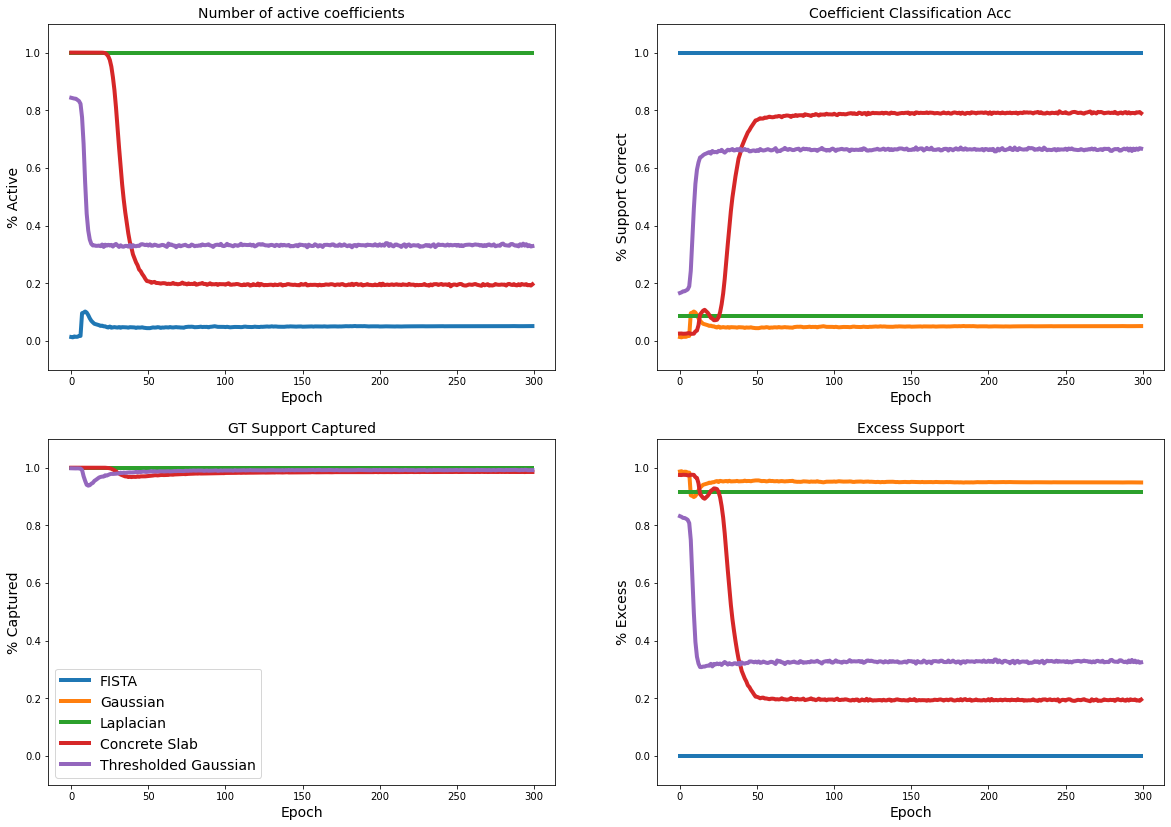

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

for idx, label in enumerate(file_labels):
    if idx == 0:
        ax[0, 0].plot(true_active_coeff[label], linewidth=4, label="FISTA")
        ax[0, 1].plot(np.ones(len(classification_acc[label])), linewidth=4, label="FISTA")
        ax[1, 0].plot(np.ones(len(num_true_supp[label])), linewidth=4, label="FISTA")
        ax[1, 1].plot(np.zeros(len(num_true_supp[label])), linewidth=4, label="FISTA")        
    ax[0, 0].plot(est_active_coeff[label], linewidth=4, label=label)
    ax[0, 1].plot(classification_acc[label], linewidth=4, label=label)
    ax[1, 0].plot(num_true_supp[label], linewidth=4, label=label)
    ax[1, 1].plot(num_redundant_supp[label], linewidth=4, label=label)

#ax[0, 0].legend(fontsize=14)
ax[0, 0].set_title("Number of active coefficients", fontsize=14)
ax[0, 0].set_xlabel("Epoch", fontsize=14)
ax[0, 0].set_ylabel("% Active", fontsize=14)
ax[0, 0].set_ylim([-.1, 1.1])

#ax[0, 1].legend(fontsize=14)
ax[0, 1].set_title("Coefficient Classification Acc", fontsize=14)
ax[0, 1].set_xlabel("Epoch", fontsize=14)
ax[0, 1].set_ylabel("% Support Correct", fontsize=14)
ax[0, 1].set_ylim([-.1, 1.1])

ax[1, 0].legend(fontsize=14)
ax[1, 0].set_title("GT Support Captured", fontsize=14)
ax[1, 0].set_xlabel("Epoch", fontsize=14)
ax[1, 0].set_ylabel("% Captured", fontsize=14)
ax[1, 0].set_ylim([-.1, 1.1])

#ax[1, 1].legend(fontsize=14)
ax[1, 1].set_title("Excess Support", fontsize=14)
ax[1, 1].set_xlabel("Epoch", fontsize=14)
ax[1, 1].set_ylabel("% Excess", fontsize=14)
ax[1, 1].set_ylim([-.1, 1.1])


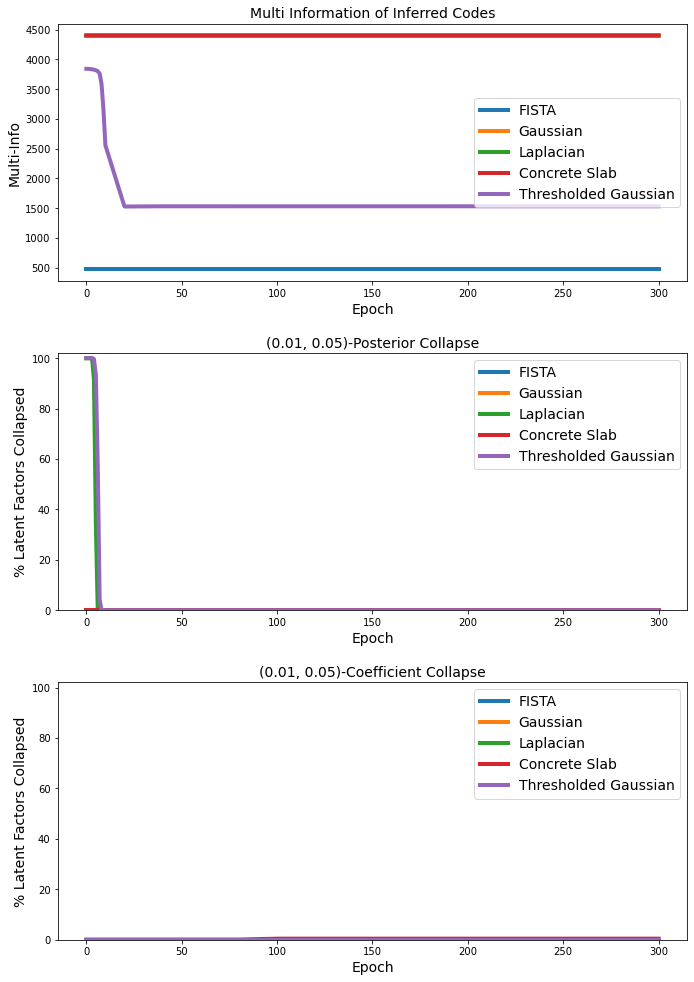

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 14))

for idx, label in enumerate(file_labels):
    if idx == 0:
        print()
        ax[0].plot(stat_step[label], 4.706e+02 * np.ones(len(multi_info[label])), linewidth=4, label="FISTA")
        ax[1].plot(stat_step[label], np.zeros(len(posterior_collapse[label])), linewidth=4, label="FISTA")
        ax[2].plot(stat_step[label], np.zeros(len(coeff_collapse[label])), linewidth=4, label="FISTA")
    ax[0].plot(stat_step[label], multi_info[label], linewidth=4, label=label)
    ax[1].plot(stat_step[label], posterior_collapse[label], linewidth=4, label=label)
    ax[2].plot(stat_step[label], coeff_collapse[label], linewidth=4, label=label)

ax[0].legend(fontsize=14)
ax[0].set_title("Multi Information of Inferred Codes", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].set_ylabel("Multi-Info", fontsize=14)

ax[1].legend(fontsize=14)
ax[1].set_title("(0.01, 0.05)-Posterior Collapse", fontsize=14)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].set_ylabel("% Latent Factors Collapsed", fontsize=14)
ax[1].set_ylim([-.1, 102])

ax[2].legend(fontsize=14)
ax[2].set_title("(0.01, 0.05)-Coefficient Collapse", fontsize=14)
ax[2].set_xlabel("Epoch", fontsize=14)
ax[2].set_ylabel("% Latent Factors Collapsed", fontsize=14)
ax[2].set_ylim([-.1, 102])

fig.tight_layout(pad=2.0)



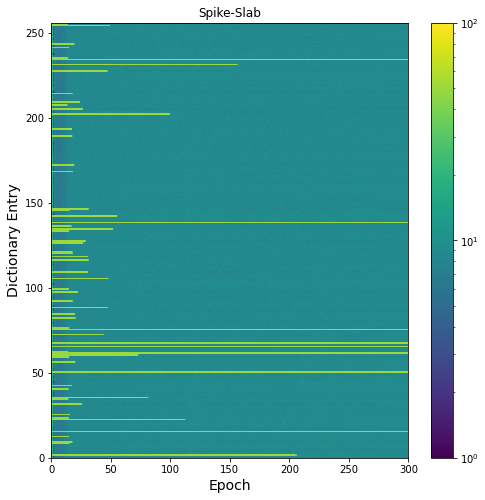

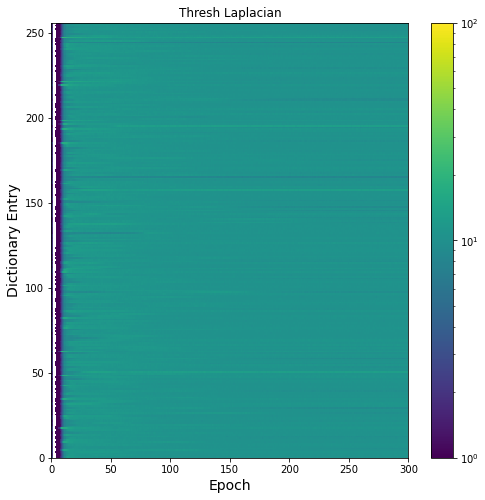

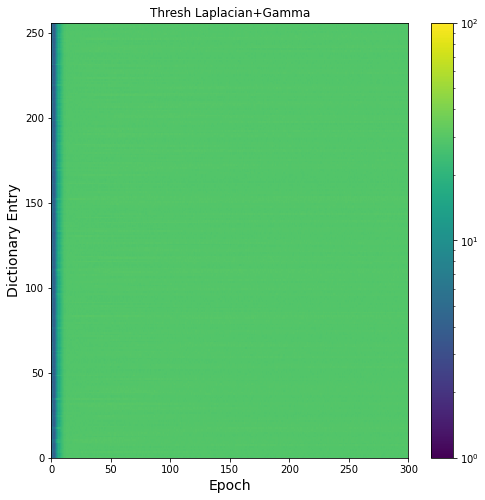

In [12]:
from matplotlib.colors import LogNorm

for idx, label in enumerate(file_labels):
    plt.figure(figsize=(8, 8))

    plt.pcolormesh(dictionary_use_dict[label].T, norm=LogNorm(vmin=1, vmax=100))
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Dictionary Entry", fontsize=14)
    plt.title(label)
    plt.colorbar()

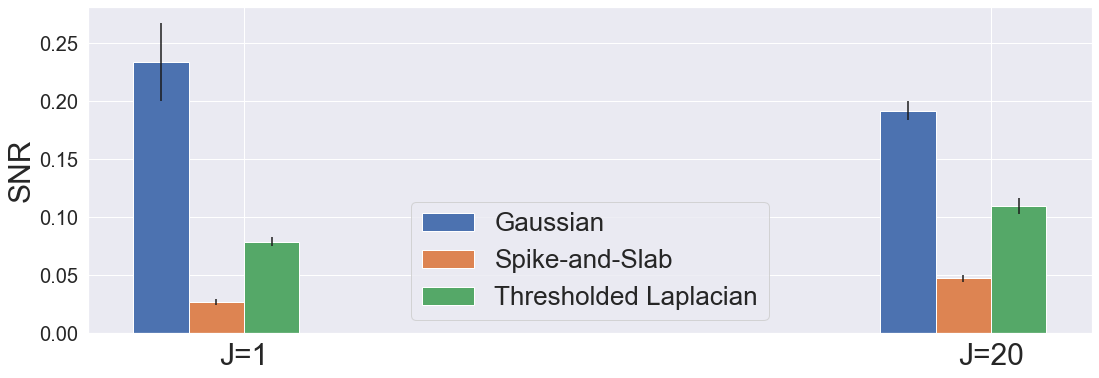

In [5]:
plt_colors = sns.color_palette()

J1_vsc_mean = {
    "Gaussian":                     2.34e-1,
    "Spike-and-Slab":               2.70e-2,
    "Thresholded Laplacian":        7.89e-2, 
}

J1_vsc_std = {
    "Gaussian":                     3.39e-2,
    "Spike-and-Slab":               2.23e-3,
    "Thresholded Laplacian":        3.89e-3, 
}

J20_vsc_mean = {
    "Gaussian":                     1.92e-1,
    "Spike-and-Slab":               4.74e-2,
    "Thresholded Laplacian":        1.10e-1, 
}

J20_vsc_std = {
    "Gaussian":                     8.02e-3,
    "Spike-and-Slab":               2.83e-3,
    "Thresholded Laplacian":        6.98e-3, 
}

plt.figure(figsize=(18,6))
for idx, key in enumerate(J1_vsc_mean.keys()):
    plt.bar(idx*0.4, J1_vsc_mean[key], width=0.4, yerr=J1_vsc_std[key], 
            color=plt_colors[idx], label=key)
    plt.bar(idx*0.4 + 2.4 + 3, J20_vsc_mean[key], width=0.4, yerr=J20_vsc_std[key], 
            color=plt_colors[idx], label=key)
plt.xticks([0.6, 3 + 3], ["J=1","J=20"], fontsize=30)
plt.yticks(fontsize=20)
plt.ylabel("SNR", fontsize=30)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=26)

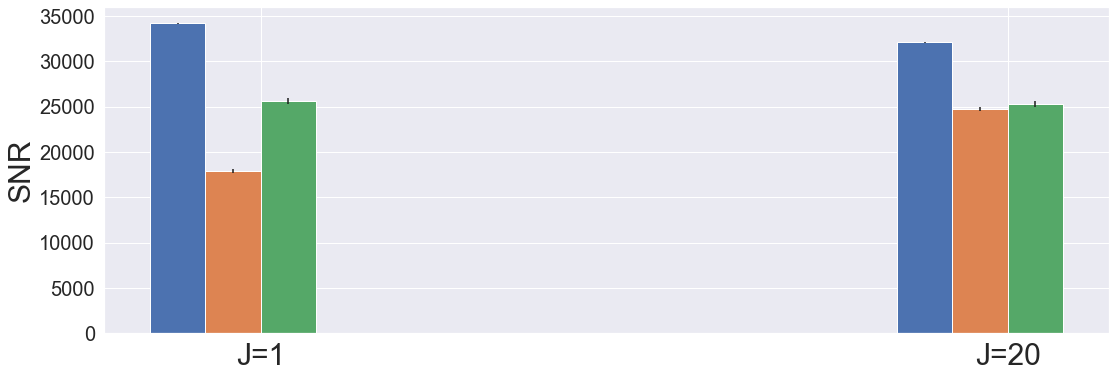

In [4]:
plt_colors = sns.color_palette()

J1_dict_mean = {
    "Gaussian":                     3.42e4,
    "Spike-and-Slab":               1.79e4,
    "Thresholded Laplacian":        2.564e4, 
}

J1_dict_std = {
    "Gaussian":                     8.54e1,
    "Spike-and-Slab":               2.22e2,
    "Thresholded Laplacian":        3.06e2, 
}

J20_dict_mean = {
    "Gaussian":                     3.21e4,
    "Spike-and-Slab":               2.48e4,
    "Thresholded Laplacian":        2.53e4, 
}

J20_dict_std = {
    "Gaussian":                     1.33e2,
    "Spike-and-Slab":               5.04e2,
    "Thresholded Laplacian":        1.50e2, 
}

plt.figure(figsize=(18,6))
for idx, key in enumerate(J1_dict_mean.keys()):
    plt.bar(idx*0.4, J1_dict_mean[key], width=0.4, yerr=J1_dict_std[key], 
            color=plt_colors[idx], label=key)
    plt.bar(idx*0.4 + 2.4 + 3, J20_dict_mean[key], width=0.4, yerr=J1_dict_std[key], 
            color=plt_colors[idx], label=key)
plt.xticks([0.6, 3 + 3], ["J=1","J=20"], fontsize=30)
plt.yticks(fontsize=20)
plt.ylabel("SNR", fontsize=30)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), fontsize=14)